In [273]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
import math 
import random

## pre-processing data

#### load the data 

In [274]:
dataset = pd.read_csv('Country-data.csv')
del dataset["country"]
print(len(dataset))
dataset.head()

167


,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


#### check for outliers and remove them

In [275]:
def find_outliers(col):
    q1 = col.quantile(.25)
    q3 = col.quantile(.75)
    IQR = q3 - q1
    ll = q1 - (1.5*IQR)
    ul = q3 + (1.5*IQR)
    upper_outliers = col[col > ul].index.tolist()
    lower_outliers = col[col < ll].index.tolist()
    bad_indices = list(set(upper_outliers + lower_outliers))
    return(bad_indices,lower_outliers,upper_outliers)

bad_indexes = []
for col in dataset.columns:
    if dataset[col].dtype in ["int64","float64"]:
        BI,lower,upper = find_outliers(dataset[col])
        bad_indexes.append(BI)
        dataset.drop(upper, inplace = True)
        dataset.drop(lower, inplace = True)
         

bad_indexes = set(list(np.concatenate(bad_indexes).flat))
print(len(bad_indexes))
print(len(dataset))
dataset.head()


42
125


,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


#### normalize the data

In [276]:
scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(dataset)

<AxesSubplot: >

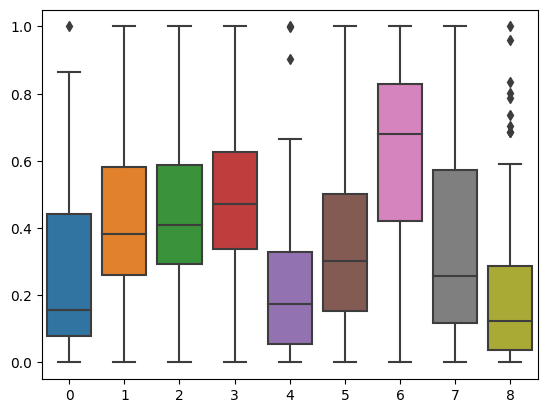

In [277]:
sns.boxplot(data=normalized_data)  

## PCA from scratch

In [278]:
def PCA(data,num_component):
    X_meaned = data - np.mean(data , axis = 0)

    cov_mat = np.cov(X_meaned , rowvar = False)

    eigen_values , eigen_vectors = np.linalg.eigh(cov_mat)

    sorted_index = np.argsort(eigen_values)[::-1]
    sorted_eigenvalue = eigen_values[sorted_index]
    sorted_eigenvectors = eigen_vectors[:,sorted_index]
    
    eigenvector_subset = sorted_eigenvectors[:,0:num_component]
    X_reduced = np.dot(eigenvector_subset.transpose(),X_meaned.transpose()).transpose()
    return X_reduced

x_reduced = PCA(normalized_data,2)

## fuzzy c-mean model


In [279]:
def euclidean_distance(point1,point2):
    dis=0
    for i in range(len(point1)):
        dis+=(point1[i]-point2[i])**2
        
    return dis**0.5

def initialize_membership_matrix(n,c):
    member_mat=list()
    for i in range(n):
        random_list=[random.random() for x in range(c)]
        summation=sum(random_list)
        for i in range(len(random_list)):
            random_list[i]=random_list[i]/summation
        member_mat.append(random_list)
        
    return member_mat

def update_centroid(member_mat,data,n,c,p):
    centroids={}

    for j in range(c):
        temp=[]
        for k in range(p):
            
            add=0
            for i in range(n):
                add+=member_mat[i][j]**2
            x=0
            for i in range(n):
                x+=(member_mat[i][j]**2)*(data[i][k])
            val=x/add
            temp.append(val)
        centroids[j]=temp
    return centroids


def update_membership_matrix(member_mat,centroids,data,n,c):
    ratio=float(2/(2-1))

    for i in range(n):
        distances=list()
        for j in range(c):
            distances.append(euclidean_distance(data[i],centroids[j]))
        for j in range(c):
            den = sum([math.pow(float(distances[j]/distances[q]), ratio) for q in range(c)])
            member_mat[i][j] = float(1/den) 
           
    return member_mat
        
                
def find_cluster(member_mat,n):
    clusters=list()
    for i in range(n):
        max_val, idx = max((val, idx) for (idx, val) in enumerate(member_mat[i]))
        clusters.append(idx)
    return clusters

def check(old_member_mat,member_mat,n,c):
    diff=0
    for i in range(n):
        for j in range(c):
            diff+=old_member_mat[i][j]-member_mat[i][j]
    if(diff<0.01):
        return True
    return False

def fuzzy_c_mean(data,n,c,max_iter,p):
    member_mat=initialize_membership_matrix(n,c)
    for i in range(max_iter):
        centroids=update_centroid(member_mat,data,n,c,p)
        old_member_mat=member_mat
        member_mat=update_membership_matrix(member_mat,centroids,data,n,c)
        cluster=find_cluster(member_mat,n)
        if(check(old_member_mat,member_mat,n,c))<0.01:
            print(i)
            break
    
    return cluster,centroids

### before applying PCA


In [280]:
n0=len(normalized_data)
c0=2
p0=len(normalized_data[0])
max_iter0=100

labels , centroids = fuzzy_c_mean(normalized_data,n0,c0,max_iter0,p0)

In [281]:
centroids_values =  centroids.values()
centroids_values = list(centroids_values)
centroids_np0 = np.array(centroids_values)

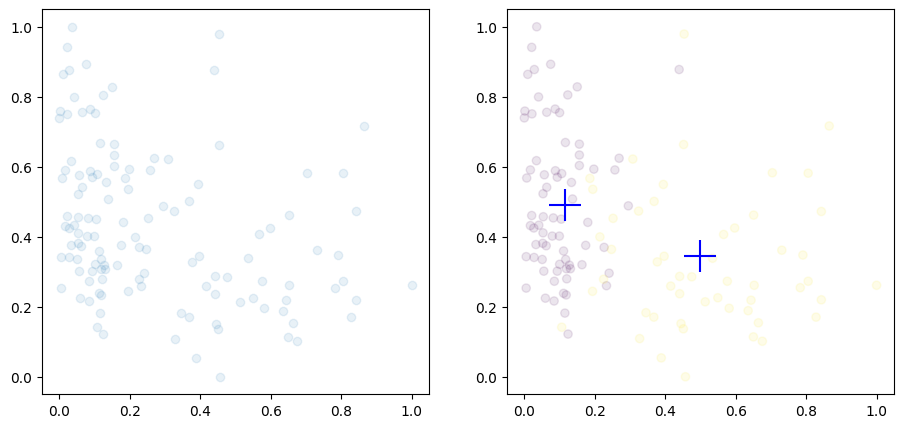

In [282]:
f, axes = plt.subplots(1, 2, figsize=(11,5))
axes[0].scatter(normalized_data[:,0], normalized_data[:,1], alpha=.1)
axes[1].scatter(normalized_data[:,0], normalized_data[:,1], c=labels, alpha=.1)
axes[1].scatter(centroids_np0[:,0], centroids_np0[:,1], marker="+", s=500, c='b')

plt.show()

### after applying PCA

In [283]:
n=len(x_reduced)
c=2
p=len(x_reduced[0])
max_iter=100

In [284]:
labels2 , centroids2 = fuzzy_c_mean(x_reduced,n,c,max_iter,p)

In [285]:
centroids_values =  centroids2.values()
centroids_values = list(centroids_values)
centroids_np = np.array(centroids_values)

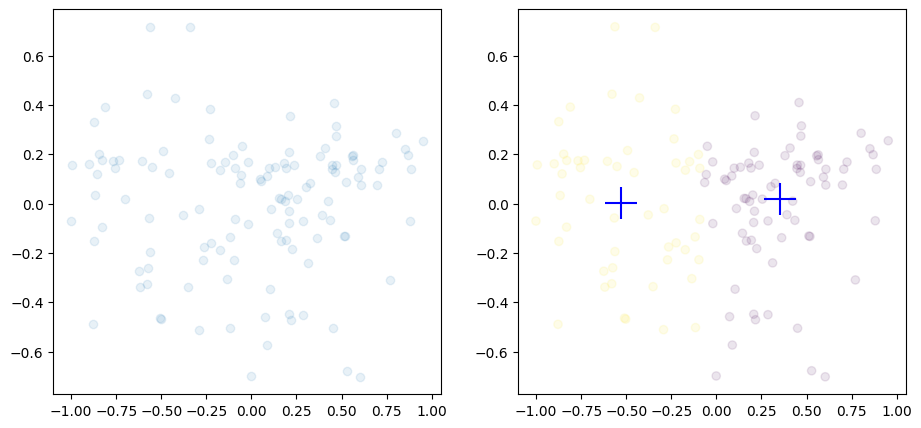

In [286]:
f, axes = plt.subplots(1, 2, figsize=(11,5))
axes[0].scatter(x_reduced[:,0], x_reduced[:,1], alpha=.1)
axes[1].scatter(x_reduced[:,0], x_reduced[:,1], c=labels2, alpha=.1)
axes[1].scatter(centroids_np[:,0], centroids_np[:,1], marker="+", s=500, c='b')

plt.show()